In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/audio-dataset-advanced/scaler_advanced.joblib
/kaggle/input/audio-dataset-advanced/audio_data_advanced.npz
/kaggle/input/audio-dataset-advanced/label_encoder_advanced.joblib
/kaggle/input/audio-spectrograms/scaler_spectrogram.joblib
/kaggle/input/audio-spectrograms/audio_data_spectrogram.npz
/kaggle/input/audio-spectrograms/label_encoder_spectrogram.joblib


In [50]:
from sklearn.utils.class_weight import compute_class_weight

In [51]:
import joblib
# --- This code goes at the start of your Kaggle Notebook ---
# --- 1. Define the path to your uploaded data ---
# The path is usually /kaggle/input/your-dataset-name
KAGGLE_INPUT_PATH = '/kaggle/input/audio-dataset-advanced' #<-- CHANGE THIS to your dataset name on Kaggle

# --- 2. Load the NumPy arrays ---
data_path = os.path.join(KAGGLE_INPUT_PATH, 'audio_data_advanced.npz')
data = np.load(data_path)

# Extract each array from the loaded .npz file
X_train_scaled = data['X_train']
X_val_scaled = data['X_val']
X_test_scaled = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

# --- 3. Load the preprocessing objects ---
scaler_path = os.path.join(KAGGLE_INPUT_PATH, 'scaler_advanced.joblib')
scaler = joblib.load(scaler_path)

label_encoder_path = os.path.join(KAGGLE_INPUT_PATH, 'label_encoder_advanced.joblib')
le = joblib.load(label_encoder_path)


# --- 4. Verify that everything loaded correctly ---
print("--- Data loading complete! ---")
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of y_train_categorical: {y_train.shape}")
print(f"Shape of X_val_scaled: {X_val_scaled.shape}")
print(f"Shape of y_val_categorical: {y_val.shape}")
print("\nLabel Encoder classes (to interpret predictions):")
print(le.classes_)

--- Data loading complete! ---
Shape of X_train_scaled: (4410, 223, 65)
Shape of y_train_categorical: (4410,)
Shape of X_val_scaled: (491, 223, 65)
Shape of y_val_categorical: (491,)

Label Encoder classes (to interpret predictions):
['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [52]:
NUM_CLASSES = len(le.classes_)

In [53]:
NUM_CLASSES

8

In [54]:
from sklearn.utils.class_weight import compute_class_weight

In [55]:
# --- 1. Setup and Data Loading ---
# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [56]:
# --- This cell performs all post-loading data preparation for the ADVANCED dataset ---
print("--- Starting: Filtering, Class Weighting, and DataLoader Creation ---")

# --- Step 1: Find the index of the 'neutral' class ---
class_names = list(le.classes_)
try:
    neutral_class_index = class_names.index('neutral')
    print(f"Original classes: {class_names}")
    print(f"Found 'neutral' class at index: {neutral_class_index}")
except ValueError:
    print("Error: 'neutral' class not found. No filtering will occur.")
    neutral_class_index = -1

if neutral_class_index != -1:
    
    # --- Step 2: Filter the training & validation data ---
    # The loaded y_train and y_val are already integer arrays, so we can use them directly.
    # NO need for np.argmax.
    
    # The mask is True for every sample that is NOT the neutral class
    train_mask = y_train != neutral_class_index
    val_mask = y_val != neutral_class_index
    
    # Apply the mask to X and y arrays
    X_train_filtered = X_train_scaled[train_mask]
    y_train_filtered = y_train[train_mask]
    
    X_val_filtered = X_val_scaled[val_mask]
    y_val_filtered = y_val[val_mask]
    
    print(f"\nOriginal training samples: {len(X_train_scaled)}")
    print(f"Filtered training samples: {len(X_train_filtered)}")
    
    # --- Step 3: Remap the labels to be continuous (e.g., [0, 1, 2, 4, 5] -> [0, 1, 2, 3, 4]) ---
    # This is crucial for the loss function.
    y_train_remapped = np.array([label if label < neutral_class_index else label - 1 for label in y_train_filtered])
    y_val_remapped = np.array([label if label < neutral_class_index else label - 1 for label in y_val_filtered])
    
    # --- Step 4: Update the label encoder for future use (e.g., classification reports) ---
    le.classes_ = np.delete(le.classes_, neutral_class_index)
    
else:
    # If neutral was not found, just use the original data without changes
    print("Proceeding without filtering.")
    X_train_filtered = X_train_scaled
    X_val_filtered = X_val_scaled
    # The labels are already correct, no remapping needed
    y_train_remapped = y_train
    y_val_remapped = y_val

# At this point, y_train_remapped is the CORRECT array to use for class weights.
# Let's rename it to 'y_train_final' for clarity.
y_train_final = y_train_remapped

# --- Step 5: Calculate new class weights on the FILTERED training data ---
print("\nCalculating class weights on the new, filtered training data...")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final  # Using the newly created, filtered, and remapped y_train
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"New classes for weighting: {list(le.classes_)}")
print(f"New class weights: {weights_tensor.cpu().numpy()}")

# --- Step 6: Create PyTorch Tensors from the FINAL filtered and remapped arrays ---
X_train_tensor = torch.from_numpy(X_train_filtered).float()
X_val_tensor = torch.from_numpy(X_val_filtered).float()

y_train_tensor = torch.from_numpy(y_train_remapped).long()
y_val_tensor = torch.from_numpy(y_val_remapped).long()

# --- Final Sanity Check ---
print("\n--- Sanity Check on Tensor Shapes ---")
print(f"Shape of X_train_tensor: {X_train_tensor.shape}")
print(f"Shape of y_train_tensor: {y_train_tensor.shape}")
print("Shapes match, ready for DataLoader creation.")

# --- Step 7: Create TensorDatasets and DataLoaders ---
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n--- DataLoaders and Class Weights created successfully with filtered data! ---")

# You will use this in your model definition
NUM_CLASSES_NEW = len(le.classes_)
print(f"New number of classes for model: {NUM_CLASSES_NEW}")

--- Starting: Filtering, Class Weighting, and DataLoader Creation ---
Original classes: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 'neutral' class at index: 5

Original training samples: 4410
Filtered training samples: 4074

Calculating class weights on the new, filtered training data...
New classes for weighting: ['angry', 'calm', 'disgust', 'fear', 'happy', 'sad', 'surprise']
New class weights: [0.8622222 0.8584071 1.6869565 0.8584071 0.8622222 0.8584071 1.6869565]

--- Sanity Check on Tensor Shapes ---
Shape of X_train_tensor: torch.Size([4074, 223, 65])
Shape of y_train_tensor: torch.Size([4074])
Shapes match, ready for DataLoader creation.

--- DataLoaders and Class Weights created successfully with filtered data! ---
New number of classes for model: 7


In [57]:
NUM_CLASSES=len(le.classes_)

In [58]:
NUM_CLASSES

7

In [59]:
# Create TensorDatasets and DataLoaders
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [60]:
import torch.nn.functional as F

# --- Luong Attention Module ---
class LuongAttention(nn.Module):
    def __init__(self):
        super(LuongAttention, self).__init__()

    def forward(self, lstm_outputs, last_hidden):
        alignment_scores = torch.bmm(lstm_outputs, last_hidden.unsqueeze(2)).squeeze(2)
        attn_weights = F.softmax(alignment_scores, dim=1)
        context_vector = torch.bmm(attn_weights.unsqueeze(1), lstm_outputs).squeeze(1)
        return context_vector, attn_weights

# --- The Main Model Architecture ---
class CNN_LSTM_Attention_Model(nn.Module):
    def __init__(self, num_features, num_classes, lstm_hidden_size=128, lstm_layers=2):
        super(CNN_LSTM_Attention_Model, self).__init__()
        
        self.lstm_hidden_size = lstm_hidden_size
        
        # --- CNN Part to learn local patterns from features ---
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2) # This slightly reduces sequence length
        )
        
        # --- LSTM Part to learn temporal dependencies ---
        # The input size for the LSTM is now 128 (from the CNN's output channels)
        self.lstm = nn.LSTM(
            input_size=128, 
            hidden_size=self.lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=0.5,
            bidirectional=True
        )
        
        # --- Attention Part ---
        self.attention = LuongAttention()
        
        # --- Classifier Head ---
        self.fc = nn.Linear(self.lstm_hidden_size * 4, num_classes) # *4 from concat(hidden, context)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, num_features)
        
        x = x.permute(0, 2, 1) # Prep for CNN: (batch, features, seq_len)
        x_cnn = self.cnn(x)
        x_cnn = x_cnn.permute(0, 2, 1) # Prep for LSTM: (batch, seq_len, features)
        
        lstm_outputs, (hidden, cell) = self.lstm(x_cnn)
        
        last_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        context_vector, attn_weights = self.attention(lstm_outputs, last_hidden)
        
        combined_vector = torch.cat((last_hidden, context_vector), dim=1)
        
        logits = self.fc(self.dropout(combined_vector))
        
        return logits

In [61]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [62]:
weights_tensor

tensor([0.8622, 0.8584, 1.6870, 0.8584, 0.8622, 0.8584, 1.6870],
       device='cuda:0')

In [63]:

# --- Get required dimensions ---
NUM_FEATURES = X_train_tensor.shape[2]

# --- Instantiate the NEW Attention model ---
model = CNN_LSTM_Attention_Model(
    num_features=NUM_FEATURES, # This will now be ~65
    num_classes=NUM_CLASSES,
    lstm_hidden_size=128 # Let's give it a bit more capacity to handle the rich features
).to(device)

# --- Define Optimizer and Loss Function ---
EPOCHS=50
LEARNING_RATE = 0.001
# Start with a moderate weight decay. Attention models can still overfit.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) 

# NO class weights, as requested
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=5, verbose=True, path='checkpoint_attention.pt')

print("--- Starting training with the new CNN+LSTM+Attention model ---")
# Now, run your existing training loop with this new setup. No other changes are needed.

--- Starting training with the new CNN+LSTM+Attention model ---


In [64]:
print("\n--- Starting Training ---")
for epoch in range(1, EPOCHS + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct_val / total_val
    
    print(f"Epoch: {epoch}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping call
    early_stopper(avg_val_loss, model)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break


--- Starting Training ---
Epoch: 1/50 | Train Loss: 1.6739 | Train Acc: 0.3061 | Val Loss: 1.4439 | Val Acc: 0.4018
Validation loss decreased (inf --> 1.443940).  Saving model ...
Epoch: 2/50 | Train Loss: 1.3998 | Train Acc: 0.4264 | Val Loss: 1.2175 | Val Acc: 0.5188
Validation loss decreased (1.443940 --> 1.217511).  Saving model ...
Epoch: 3/50 | Train Loss: 1.2277 | Train Acc: 0.5039 | Val Loss: 0.9809 | Val Acc: 0.6203
Validation loss decreased (1.217511 --> 0.980891).  Saving model ...
Epoch: 4/50 | Train Loss: 1.0718 | Train Acc: 0.5859 | Val Loss: 0.8527 | Val Acc: 0.6512
Validation loss decreased (0.980891 --> 0.852697).  Saving model ...
Epoch: 5/50 | Train Loss: 0.9398 | Train Acc: 0.6357 | Val Loss: 0.9273 | Val Acc: 0.6667
EarlyStopping counter: 1 out of 5
Epoch: 6/50 | Train Loss: 0.8283 | Train Acc: 0.6993 | Val Loss: 0.8787 | Val Acc: 0.6490
EarlyStopping counter: 2 out of 5
Epoch: 7/50 | Train Loss: 0.7800 | Train Acc: 0.7062 | Val Loss: 0.7366 | Val Acc: 0.7174
Vali

In [65]:
# --- Post-Training ---
print("\n--- Training Finished ---")
# Load the best model weights found during training
model.load_state_dict(torch.load('checkpoint_attention.pt'))
print("Best model weights loaded for final evaluation.")


--- Training Finished ---
Best model weights loaded for final evaluation.


In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


--- Generating Classification Report for Validation Set ---

Classification Report:
              precision    recall  f1-score   support

       angry       0.84      0.92      0.88        76
        calm       0.83      0.87      0.85        75
     disgust       0.78      0.66      0.71        38
        fear       0.69      0.80      0.74        75
       happy       0.80      0.83      0.81        76
         sad       0.78      0.57      0.66        75
    surprise       0.82      0.84      0.83        38

    accuracy                           0.79       453
   macro avg       0.79      0.78      0.78       453
weighted avg       0.79      0.79      0.79       453


Confusion Matrix:


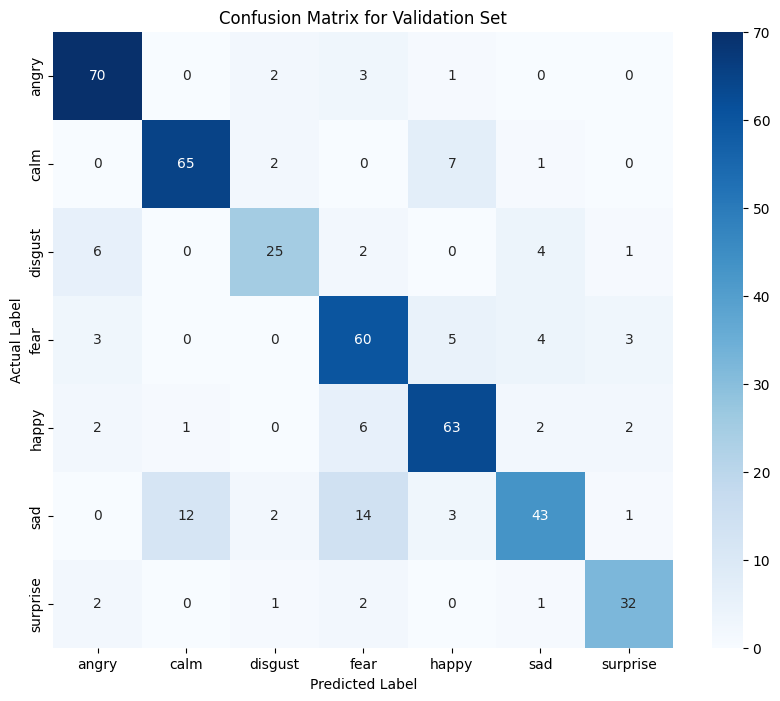

In [67]:
# --- 5. Evaluate the Final Model on the Validation Set ---
print("\n--- Generating Classification Report for Validation Set ---")

# Put the model in evaluation mode
model.eval()

# Store predictions and true labels
all_preds = []
all_labels = []

# No need to track gradients for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        # Get the predicted class (the one with the highest probability)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append batch predictions and labels to the lists
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get the class names from the label encoder
class_names = le.classes_

# Print the classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


# --- (Optional but Recommended) Visualize the Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Validation Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [68]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ==============================================================================
# FINAL EVALUATION ON THE TEST SET for the 1D CNN Model
# ==============================================================================

print("--- Starting Final Evaluation on the Unseen Test Set ---")

# --- Step 1: Ensure the model is in evaluation mode ---
model.eval()

# --- Step 2: Prepare the Test Data by FILTERING out the 'neutral' class ---
# We must do this because the model was not trained on 'neutral'.

print("Preparing test data by filtering out the 'neutral' class...")

# To do this robustly, we must know the original class list BEFORE any filtering.
# Let's assume the original order was this (common for RAVDESS).
# IMPORTANT: Adjust this list if your original order was different.
original_class_names = ['anger', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

try:
    # Find the integer index that 'neutral' had in the original, full dataset.
    neutral_class_index_original = original_class_names.index('neutral')
    print(f"The original index of the 'neutral' class was: {neutral_class_index_original}")

    # Create a boolean mask to select every sample where the label is NOT the original neutral index.
    # `y_test` holds the labels corresponding to the original full class list.
    test_mask = y_test != neutral_class_index_original

    # Apply the mask to filter both the features and the labels.
    X_test_filtered = X_test_scaled[test_mask]
    y_test_filtered = y_test[test_mask]

    print(f"\nOriginal number of test samples: {len(y_test)}")
    print(f"Number of test samples after filtering 'neutral': {len(y_test_filtered)}")

    # **CRUCIAL**: Remap the remaining labels to match the model's output (0, 1, 2, ...).
    # This collapses the gap left by removing the neutral class.
    y_test_remapped = np.array([label if label < neutral_class_index_original else label - 1 for label in y_test_filtered])

except ValueError:
    print("'neutral' class not found in the assumed original list. Proceeding without filtering.")
    # This block runs if 'neutral' was somehow already removed from the test set.
    X_test_filtered = X_test_scaled
    y_test_remapped = y_test


# --- Step 3: Convert to Tensors and Create DataLoader ---
# We now use the filtered and remapped data.
X_test_tensor = torch.from_numpy(X_test_filtered).float()
y_test_tensor = torch.from_numpy(y_test_remapped).long()

BATCH_SIZE = 32
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nTest DataLoader created with filtered data.")


--- Starting Final Evaluation on the Unseen Test Set ---
Preparing test data by filtering out the 'neutral' class...
The original index of the 'neutral' class was: 5

Original number of test samples: 491
Number of test samples after filtering 'neutral': 453

Test DataLoader created with filtered data.


In [69]:
X_test_tensor.shape

torch.Size([453, 223, 65])

In [70]:
# --- Step 4: Run Inference on the Filtered Test Set ---
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Inference complete.")


Inference complete.


In [71]:
# --- Step 5: Calculate and Print Final Metrics ---
# The label encoder 'le' should be the one from AFTER filtering 'neutral'
# It will contain the correct class names for the report.
class_names = le.classes_

# Sanity check: ensure the number of classes matches the model's understanding
if len(class_names) != model.fc.out_features:
     print(f"WARNING: Class name count ({len(class_names)}) does not match model output count ({model.fc.out_features}).")

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n======================================================================")
print(f"FINAL TEST ACCURACY (on known classes): {final_accuracy * 100:.2f}%")
print(f"======================================================================")

print("\nClassification Report (on known classes):")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))



FINAL TEST ACCURACY (on known classes): 78.15%

Classification Report (on known classes):
              precision    recall  f1-score   support

       angry      0.890     0.867     0.878        75
        calm      0.868     0.880     0.874        75
     disgust      0.800     0.821     0.810        39
        fear      0.708     0.613     0.657        75
       happy      0.783     0.867     0.823        75
         sad      0.658     0.693     0.675        75
    surprise      0.757     0.718     0.737        39

    accuracy                          0.781       453
   macro avg      0.781     0.780     0.779       453
weighted avg      0.781     0.781     0.780       453




Confusion Matrix (on known classes):


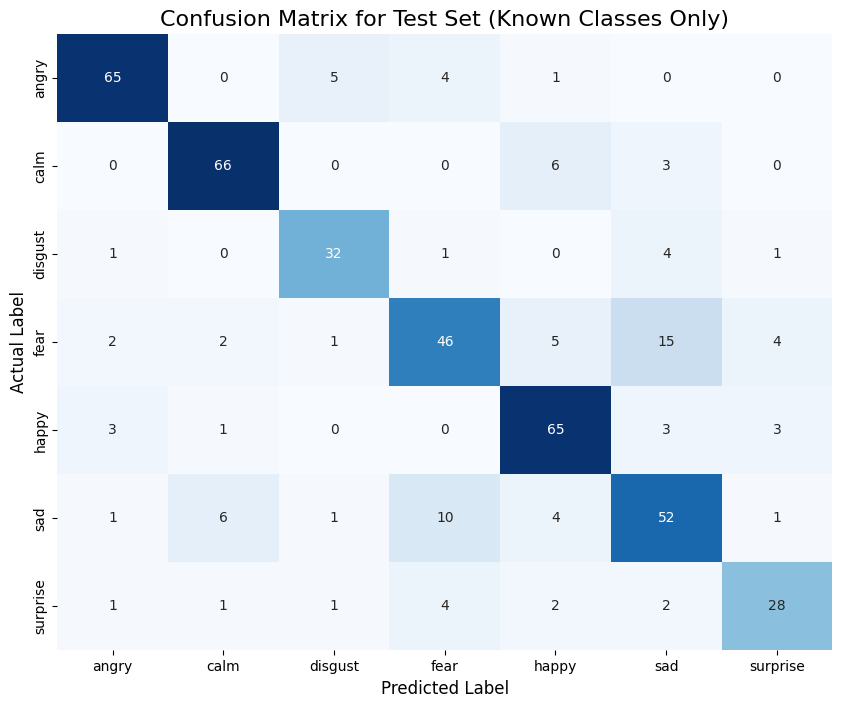

In [72]:


# --- Step 6: Visualize the Confusion Matrix ---
print("\nConfusion Matrix (on known classes):")
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Test Set (Known Classes Only)', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [ ]:
import shutil

In [ ]:
DOWNLOAD_DIR = 'final_model_artifacts'
if os.path.exists(DOWNLOAD_DIR):
    shutil.rmtree(DOWNLOAD_DIR) # Clean up old folder if it exists
os.makedirs(DOWNLOAD_DIR)

print(f"Created a new directory for downloads: '{DOWNLOAD_DIR}'")

# --- 1. Define paths for all files ---

# Path to the best model weights saved by EarlyStopping
# Make sure this matches the 'path' argument in your EarlyStopping instance
BEST_MODEL_PATH_SOURCE = 'checkpoint_attention.pt' # Or whatever you named it

# Destination path inside our new download folder
BEST_MODEL_PATH_DEST = os.path.join(DOWNLOAD_DIR, 'best_model.pt')

# Paths to the scaler and encoder you loaded from your Kaggle dataset
# Make sure KAGGLE_INPUT_PATH is correctly defined
KAGGLE_INPUT_PATH = '/kaggle/input/audio-dataset-advanced' #<-- CHANGE THIS
SCALER_PATH_SOURCE = os.path.join(KAGGLE_INPUT_PATH, 'scaler_advanced.joblib')
ENCODER_PATH_SOURCE = os.path.join(KAGGLE_INPUT_PATH, 'label_encoder_advanced.joblib')

# Destination paths for the scaler and encoder
SCALER_PATH_DEST = os.path.join(DOWNLOAD_DIR, 'scaler.joblib')
ENCODER_PATH_DEST = os.path.join(DOWNLOAD_DIR, 'label_encoder.joblib')


# --- 2. Copy all the files into the download folder ---

try:
    shutil.copyfile(BEST_MODEL_PATH_SOURCE, BEST_MODEL_PATH_DEST)
    print(f"  - Copied model weights to '{BEST_MODEL_PATH_DEST}'")
    
    shutil.copyfile(SCALER_PATH_SOURCE, SCALER_PATH_DEST)
    print(f"  - Copied scaler to '{SCALER_PATH_DEST}'")
    
    shutil.copyfile(ENCODER_PATH_SOURCE, ENCODER_PATH_DEST)
    print(f"  - Copied label encoder to '{ENCODER_PATH_DEST}'")

except FileNotFoundError as e:
    print(f"\nERROR: A source file was not found. Please check your paths.")
    print(f"Details: {e}")

# --- 3. (Optional but Recommended) Create a ZIP file for easy download ---

# The output of a Kaggle notebook is in the /kaggle/working/ directory
shutil.make_archive('final_model_package', 'zip', DOWNLOAD_DIR)

print("\n--- All Done! ---")
print("A ZIP file named 'final_model_package.zip' has been created in the output directory.")
print("You can now download this single file from the Kaggle interface.")